# Elasticidade de preço - Sales:

### Objetivos:
- Identificar insights sobre os produtos relacionados a  giro e faturamento
- Criar modelo de elasticidade de preços para verificar quais produtos são mais propensos ao aumento de ticket
- Mostrar impactos financeiro sobre a decisão de aumento de ticket médio
---
Para esse projeto vou utilizar a seguinte estrutura:

1. Definição do problema (Pode ser encontrada no ReadMe)
2. Coletar dados e gerar uma visão geral
3. Dividir em treinamento e teste
4. EDA - Analise exploratória de dados
5. Feature engineering, limpeza e pré processamento.
6. Treinamento de modelo e feature selection.
7. Produção final do modelo, avaliação e testes.
8. Conclusão e interpretar resultados.
9. Deploy
---
### Estrutura do Dataset:
| Coluna        | Descrição                                                           |
|---------------|---------------------------------------------------------------------|
| Sales Person  | *Nome do vendedor responsável pela transação*                       |
| Country	      | *Região de vendas ou localização da loja onde a transação ocorreu*  |
| Product       | *Nome do produto de chocolate vendido*                              |
| Date          | *A data da transação da venda de chocolate*                         |
| Amount        | *Receita total gerada a partir da venda.*                           |
| Boxes Shipped | *Número de caixas de chocolate enviadas na ordem.*              |



#### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from elasticidadepreco.outliers import outliersCalc
from elasticidadepreco.elasticidade import elasticidade

import warnings

warnings.filterwarnings('ignore')

#### Entendendo os dados

link dataset:https://www.kaggle.com/datasets/atharvasoundankar/chocolate-sales?select=Chocolate+Sales.csv

In [2]:
df = pd.read_csv('../data/raw/Chocolate Sales.csv', encoding='utf-8')

In [3]:
df.head()

,Sales Person,Country,Product,Date,Amount,Boxes Shipped
0,Jehu Rudeforth,UK,Mint Chip Choco,04-Jan-22,"$5,320",180
1,Van Tuxwell,India,85% Dark Bars,01-Aug-22,"$7,896",94
2,Gigi Bohling,India,Peanut Butter Cubes,07-Jul-22,"$4,501",91
3,Jan Morforth,Australia,Peanut Butter Cubes,27-Apr-22,"$12,726",342
4,Jehu Rudeforth,UK,Peanut Butter Cubes,24-Feb-22,"$13,685",184


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Sales Person   1094 non-null   object
 1   Country        1094 non-null   object
 2   Product        1094 non-null   object
 3   Date           1094 non-null   object
 4   Amount         1094 non-null   object
 5   Boxes Shipped  1094 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 51.4+ KB


In [5]:
print(f'{df.shape[0]} linhas  \n{df.shape[1]} colunas')

1094 linhas  
6 colunas


In [6]:
df.describe()

,Boxes Shipped
count,1094.000000
mean,161.797989
std,121.544145
min,1.000000
25%,70.000000
50%,135.000000
75%,228.750000
max,709.000000


In [7]:
df.isnull().sum()

Sales Person     0
Country          0
Product          0
Date             0
Amount           0
Boxes Shipped    0
dtype: int64

In [8]:
df.duplicated().sum()

0

- Vou alterar o nome de colunas para um formato mais amigavel
- E alterar os tipos para facilitar os processos
- E limpar um pouco a variavel de preço e data, para gerar analises mais precisas

In [9]:
df = df.rename(columns={
    'Sales Person': 'sales_person',
    'Country': 'country',
    'Product': 'product',
    'Date': 'date',
    'Amount': 'amount',
    'Boxes Shipped': 'boxes_shipped',
})

In [10]:
df['amount'] = df['amount'].str.replace('[\$,]', '', regex=True).str.strip().astype(int)

In [11]:
df['country'] = df['country'].astype('category')

In [12]:
df['date'] = pd.to_datetime(df['date'], format='%d-%b-%y')

In [13]:
df = elasticidade(df, 'boxes_shipped', 'amount')

- Criei uma função só pra calcular a elasticidade, pois vou trabalhar com essa nova feature como variavel dependente. Fiz essa escolha porque facilita muito o calculo da elasticidade, que é o foco aqui, não gera perigo de vazamento de dados e na implantação do projeto consigo trabalhar com novos dados criando uma etapa anterior a aplicação do modelo, vou mostrar isso na etapa de deploy

#### Divisão de treinamento e testes

- Vou splitar os dados agora para não sofrer com  vazamento de dados nem com overfitting, e para garantir que a avaliação do modelo será com dados mais próximos do cenário real (dado o projeto)

In [14]:
X = df.drop(columns=['elasticity'])
y = df['elasticity'].copy()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [16]:
print(f'X_train shape: {X_train.shape}.')
print(f'x_train shape: {y_train.shape}.')
print(f'X_test shape: {X_test.shape}.')
print(f'y_test shape: {y_test.shape}.')

X_train shape: (875, 8).
x_train shape: (875,).
X_test shape: (219, 8).
y_test shape: (219,).


#### Analise Exploratória de Dados - EDA

- Vou analisar os dados de treinos para entender melhor seu comportamento, encontrar insights sobre o negócio. Além de procurar relacionamentos, correlações, tendênciais e demais coisas que possam ajudar na modelagem e na resolução de negócios
- Vou a analise em 3 etapas, passando por uma analise univariada, bivariada e multivariada
- E aplicar bastante gráfico e visualização para ter clareza das próximas decisões que vou tomar

In [17]:
train = pd.concat([X_train, y_train], axis=1)
train.head()

,sales_person,country,product,date,amount,boxes_shipped,change_qtd,change_price,elasticity
6,Oby Sorrel,UK,99% Dark & Pure,2022-01-25,13685,176,3.631579,1.545573,2.349665
789,Ches Bonnell,New Zealand,Caramel Stuffed Bars,2022-06-30,7588,42,-0.848375,2.763889,-0.306950
1049,Ches Bonnell,India,99% Dark & Pure,2022-02-16,455,96,0.263158,-0.875240,-0.300669
837,Kaine Padly,Australia,50% Dark Bites,2022-08-02,8995,78,-0.748387,1.466411,-0.510353
661,Gunar Cockshoot,Canada,50% Dark Bites,2022-01-04,3024,23,-0.303030,0.213483,-1.419458


In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 875 entries, 6 to 860
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   sales_person   875 non-null    object        
 1   country        875 non-null    category      
 2   product        875 non-null    object        
 3   date           875 non-null    datetime64[ns]
 4   amount         875 non-null    int32         
 5   boxes_shipped  875 non-null    int64         
 6   change_qtd     874 non-null    float64       
 7   change_price   874 non-null    float64       
 8   elasticity     874 non-null    float64       
dtypes: category(1), datetime64[ns](1), float64(3), int32(1), int64(1), object(2)
memory usage: 59.2+ KB


In [19]:
numeric_features = train.select_dtypes(include=[np.number])
categorical_features = train.select_dtypes(exclude=[np.number,np.datetime64])

Vou analisar a distribuição dos dados categóricos para identificar valores mais comuns e ter uma visão melhor das categoricas para saber a melhor maneira de trabalhar com elas

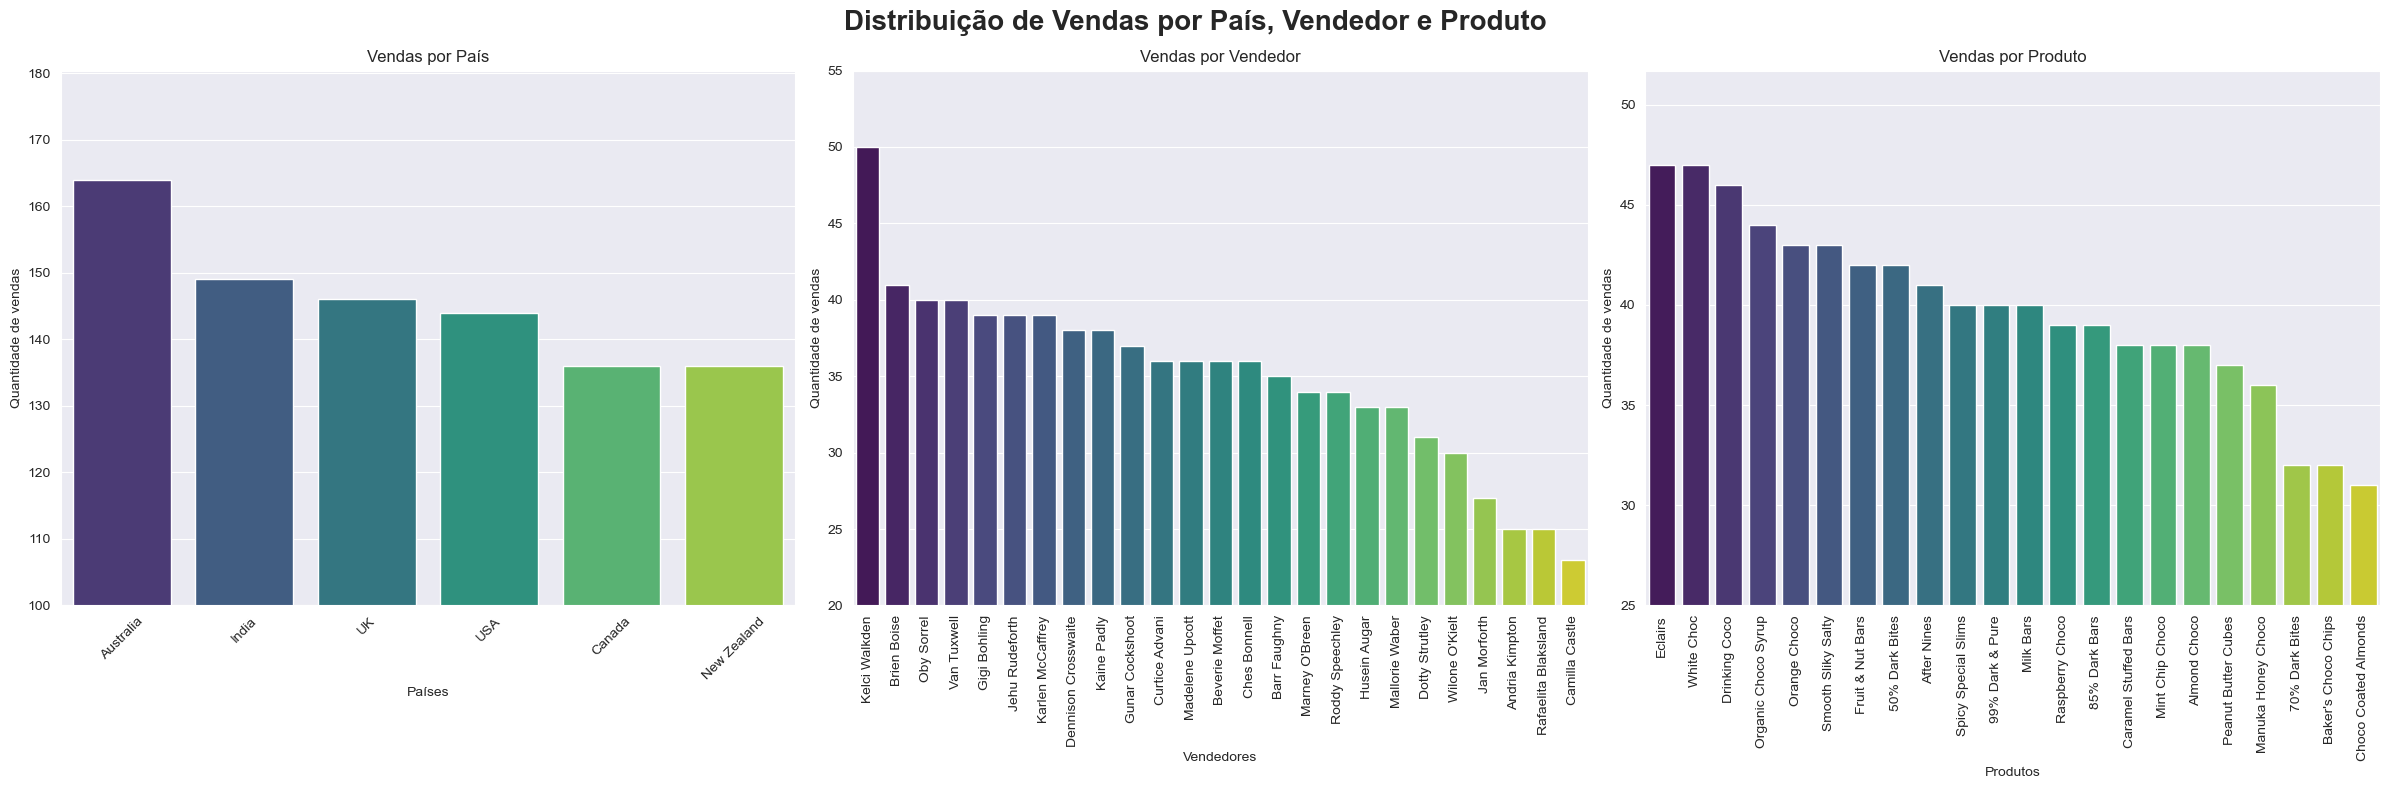

In [20]:
qtdPaises = len(train['country'].unique())
qtdVendedores = len(train['sales_person'].unique())
qtdProdutos = len(train['product'].unique())

fig, ax = plt.subplots(1, 3, figsize=(24, 8))

sns.countplot(
    ax=ax[0],
    data=train,
    x='country',
    palette=sns.color_palette("viridis", qtdPaises),
    order=train['country'].value_counts().index
)
ax[0].set_ylim(100, train['country'].value_counts().max() * 1.1)
ax[0].set_xlabel('Países')
ax[0].set_ylabel('Quantidade de vendas')
ax[0].set_title('Vendas por País')
ax[0].tick_params(axis='x', rotation=45)

sns.countplot(
    ax=ax[1],
    data=train,
    x='sales_person',
    palette=sns.color_palette("viridis", qtdVendedores),
    order=train['sales_person'].value_counts().index
)
ax[1].set_ylim(20, train['sales_person'].value_counts().max() * 1.1)
ax[1].set_xlabel('Vendedores')
ax[1].set_ylabel('Quantidade de vendas')
ax[1].set_title('Vendas por Vendedor')
ax[1].tick_params(axis='x', rotation=90)

sns.countplot(
    ax=ax[2],
    data=train,
    x='product',
    palette=sns.color_palette("viridis", qtdProdutos),
    order=train['product'].value_counts().index
)
ax[2].set_ylim(25, train['product'].value_counts().max() * 1.1)
ax[2].set_xlabel('Produtos')
ax[2].set_ylabel('Quantidade de vendas')
ax[2].set_title('Vendas por Produto')
ax[2].tick_params(axis='x', rotation=90)

fig.suptitle(
    "Distribuição de Vendas por País, Vendedor e Produto",
    fontsize=20,
    fontweight="bold",
)
plt.tight_layout()
plt.show()


In [21]:
print('-' * 40)
print(f'Total de valores únicos:{categorical_features['sales_person'].nunique()}')
print('-' * 40)
print(f'Valores: {categorical_features["sales_person"].value_counts().sort_values(ascending=False)}')

----------------------------------------
Total de valores únicos:25
----------------------------------------
Valores: sales_person
Kelci Walkden          50
Brien Boise            41
Oby Sorrel             40
Van Tuxwell            40
Gigi Bohling           39
Jehu Rudeforth         39
Karlen McCaffrey       39
Dennison Crosswaite    38
Kaine Padly            38
Gunar Cockshoot        37
Ches Bonnell           36
Beverie Moffet         36
Madelene Upcott        36
Curtice Advani         36
Barr Faughny           35
Marney O'Breen         34
Roddy Speechley        34
Husein Augar           33
Mallorie Waber         33
Dotty Strutley         31
Wilone O'Kielt         30
Jan Morforth           27
Andria Kimpton         25
Rafaelita Blaksland    25
Camilla Castle         23
Name: count, dtype: int64


In [22]:
print('-' * 40)
print(f'Total de valores únicos:{categorical_features['country'].nunique()}')
print('-' * 40)
print(f'Valores: {categorical_features["country"].value_counts().sort_values(ascending=False)}')

----------------------------------------
Total de valores únicos:6
----------------------------------------
Valores: country
Australia      164
India          149
UK             146
USA            144
Canada         136
New Zealand    136
Name: count, dtype: int64


In [23]:
print('-' * 40)
print(f'Total de valores únicos:{categorical_features['product'].nunique()}')
print('-' * 40)
print(f'Valores: {categorical_features["product"].value_counts().sort_values(ascending=False)}')

----------------------------------------
Total de valores únicos:22
----------------------------------------
Valores: product
Eclairs                 47
White Choc              47
Drinking Coco           46
Organic Choco Syrup     44
Orange Choco            43
Smooth Sliky Salty      43
Fruit & Nut Bars        42
50% Dark Bites          42
After Nines             41
99% Dark & Pure         40
Milk Bars               40
Spicy Special Slims     40
Raspberry Choco         39
85% Dark Bars           39
Caramel Stuffed Bars    38
Mint Chip Choco         38
Almond Choco            38
Peanut Butter Cubes     37
Manuka Honey Choco      36
70% Dark Bites          32
Baker's Choco Chips     32
Choco Coated Almonds    31
Name: count, dtype: int64


Insights:

- Em country e em sales_person , vemos que os valores com maior frequencia de vendas estão a uma grande distância do segundo colado
- Em product temos 2 chocolates com a mesma quantidade de vendas, e a distância para os outros valores não é tão significativa enquanto de countrny e sales_person
- Em crountry temos apenas 6 valores diferentes e que são não ordinais, ou seja, posso aplicar um OneHot enconding nessa feature
- sales_person possui 25 valores únicos e product possui 22
- Tenho uma hipotese de que em Australia e o vendedor Top 1 , estejam com a menor média de amount (preço) e com a maior média em quantidade de caixa vendidas. Levando em consideração o pensamento lógico de que a quantidade de vendas alta poderia indicar produtos com ticket baixo, fazendo-os focar em vender mais e mais de produtos "baratos"

Vamos analisar os dados numericos agora, e posteriormente visualizar algumas relações entre essas features

In [24]:
numeric_features.columns

Index(['amount', 'boxes_shipped', 'change_qtd', 'change_price', 'elasticity'], dtype='object')

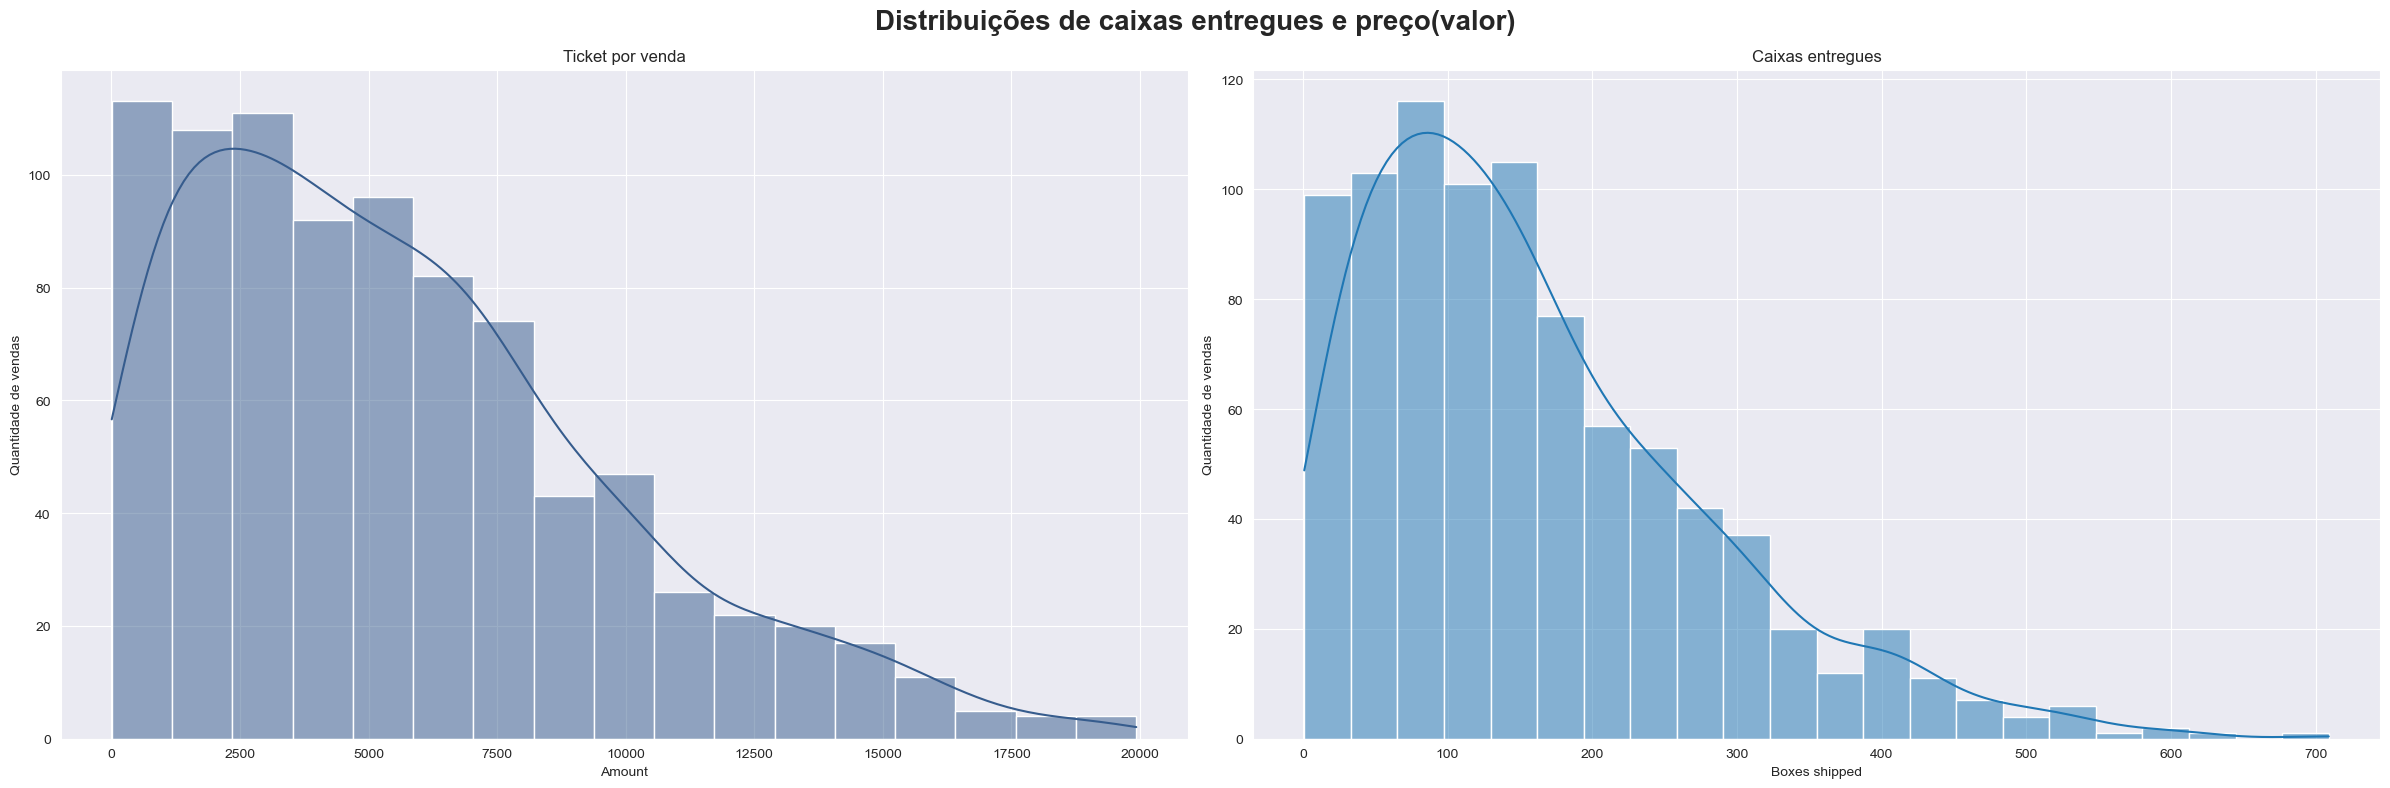

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8))

sns.histplot(
    ax=ax[0],
    kde=True,
    data=train,
    x='amount',
    color=sns.color_palette("viridis")[1]
)
ax[0].set_xlabel('Amount')
ax[0].set_ylabel('Quantidade de vendas')
ax[0].set_title('Ticket por venda')

sns.histplot(
    ax=ax[1],
    data=train,
    kde=True,
    x='boxes_shipped',
    palette=sns.color_palette("viridis")[2],
)
ax[1].set_xlabel('Boxes shipped')
ax[1].set_ylabel('Quantidade de vendas')
ax[1].set_title('Caixas entregues')

fig.suptitle(
    "Distribuições de caixas entregues e preço(valor)",
    fontsize=20,
    fontweight="bold",
)
plt.tight_layout()
plt.show()


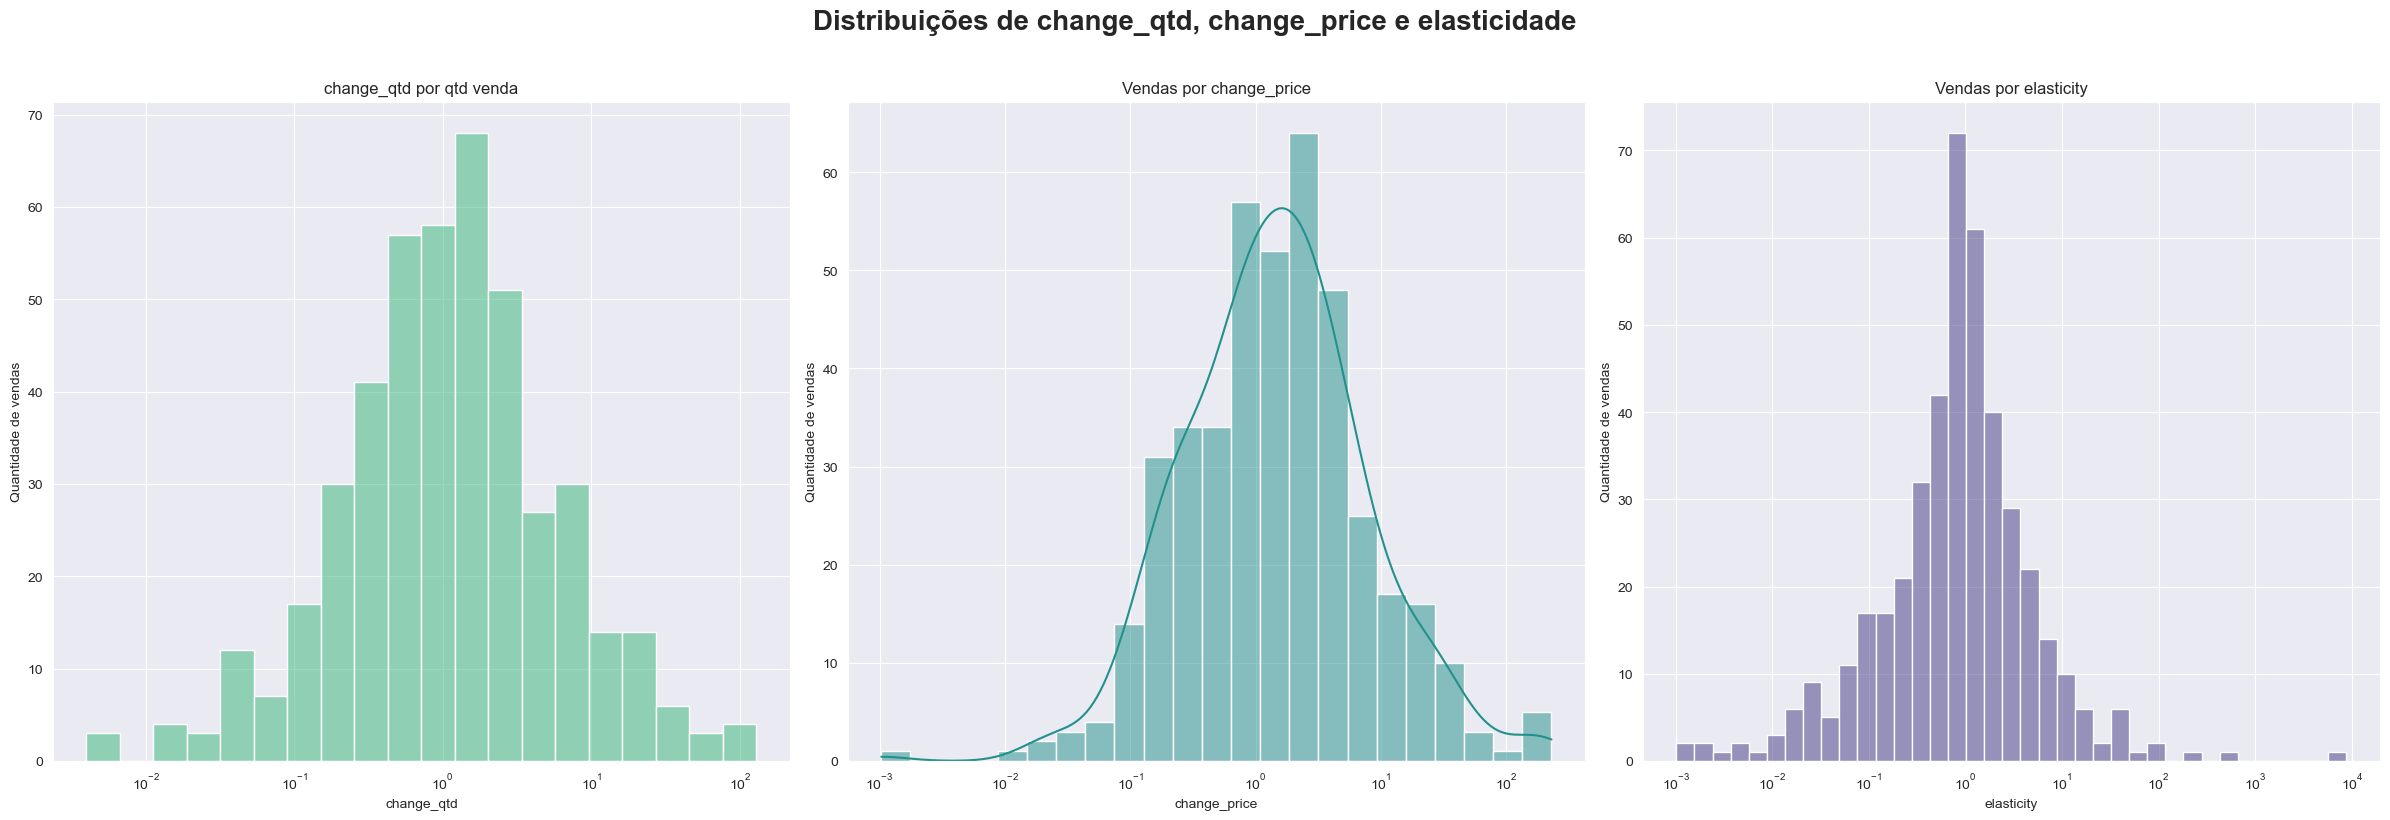

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(24, 8))

# Histograma 1
sns.histplot(
    ax=ax[0],
    data=train,
    x='change_qtd',
    color=sns.color_palette("viridis", 5)[3],  # cor única
    kde=True,
    log_scale=True
)
ax[0].set_xlabel('change_qtd')
ax[0].set_ylabel('Quantidade de vendas')
ax[0].set_title('change_qtd por qtd venda')

# Histograma 2
sns.histplot(
    ax=ax[1],
    data=train,
    x='change_price',
    color=sns.color_palette("viridis", 5)[2],  # cor única
    kde=True,
    log_scale=True
)
ax[1].set_xlabel('change_price')
ax[1].set_ylabel('Quantidade de vendas')
ax[1].set_title('Vendas por change_price')

# Histograma 3
sns.histplot(
    ax=ax[2],
    data=train,
    x='elasticity',
    color=sns.color_palette("viridis", 5)[0],  # cor única
    kde=True,
    log_scale=True
)
ax[2].set_xlabel('elasticity')
ax[2].set_ylabel('Quantidade de vendas')
ax[2].set_title('Vendas por elasticity')

# Título geral
fig.suptitle(
    "Distribuições de change_qtd, change_price e elasticidade",
    fontsize=20,
    fontweight="bold",
    y=1.02
)

plt.tight_layout()
plt.show()


Insights:

- Vemos uma semelhancia nas curva de amount e de boxes_shipped, indicando talvez uma possível relação entre essas features
- A medida em que o amount vai aumentando o numero de caixas vendidas/entregues vai diminuindo também, isso reforça minha hipotese que comentei no insghts dos dados categoricos
- Atualização da tese: 'Quando menor é o preço mais caixas sã vendidas'
- Talvez seja interessante criar faixas de preço(amount) ja que no grafico podemos observar algumas faixas(colunas) que possuem mínimos semelhantes e uma distancia baixa de max entre elas, uma faixa de preço ajudaria a mostrar de forma mais clara a diferença da frequencia(vendas) em relação ao preço
- Nos dados change_qtd, change_price e elasticty, tive que usar a log scale para conseguir visualizar os dados de forma mais clara por causa dessa normalização que eles tem
- Podemos observar que a amplitude deles é bem ampla, com alguns numeros negativos e outros bem mais avançados, isso pode indicar uma variação de preço do mesmo produto em diferentes relacionamento (pais,vendedor,quantidade,etc.) já que, na pratica, mostra que os preços aumentaram, depois diminuiram, tiveram uma variação, porém isso ocorreu poucas vezes, como mostram os graficos
- Vemos que a maior frequencia de elasticidade está indicando estar proximo ou menor que 1 (10^0), indicando uma tendência geral de produtos inelasticos e unitariamente elasticos, que significa que a variação de preço deles impacta a quantidade vendida (demanda), vou confirmar esse ponto analisando mais as correlações das features

### Outliers

In [27]:
outliers = outliersCalc(numeric_features)

In [28]:
outliers.apply(lambda x: x.sum() / x.size * 100)

amount           0.800000
boxes_shipped    1.257143
change_qtd       1.485714
change_price     1.028571
elasticity       0.228571
dtype: float64

In [37]:
df_normaliz_numeric = (numeric_features - numeric_features.mean()) / numeric_features.std()

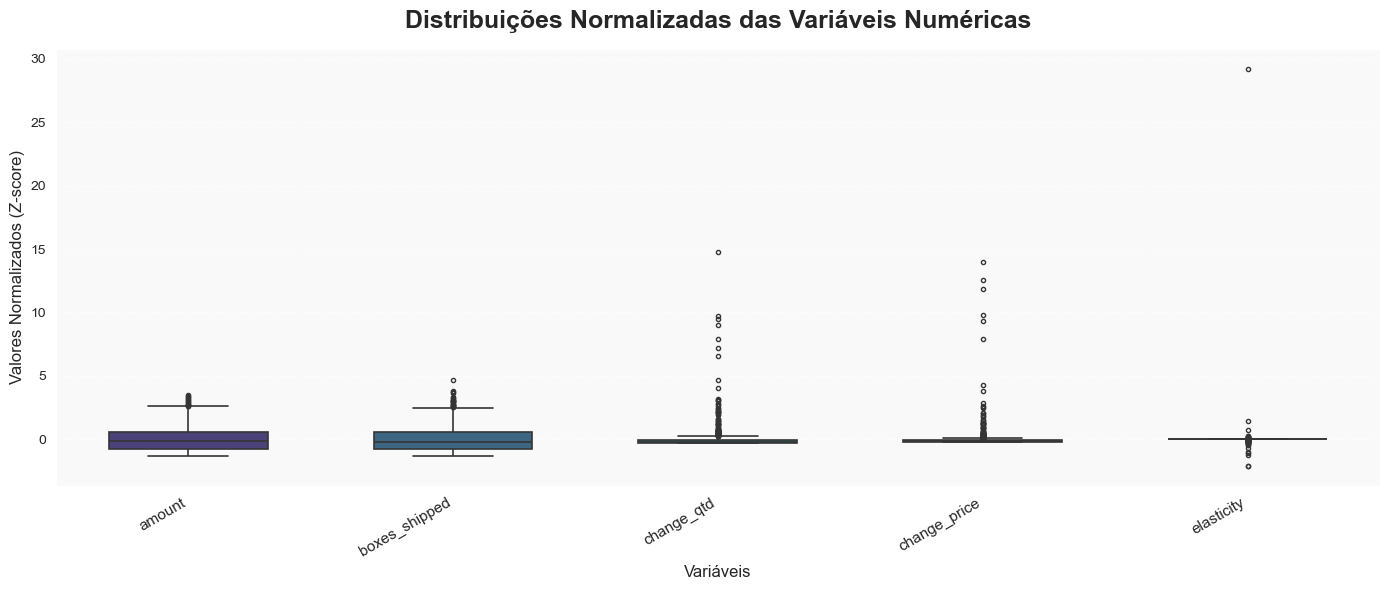

In [42]:
fig, ax = plt.subplots(figsize=(14, 6))

sns.boxplot(
    data=df_normaliz_numeric,
    palette="viridis",
    width=0.6,
    fliersize=3, # tamanho dos pontos de outliers
    linewidth=1.2,
    ax=ax
)

ax.set_title(
    "Distribuições Normalizadas das Variáveis Numéricas",
    fontsize=18,
    fontweight="bold",
    pad=15
)

ax.set_ylabel("Valores Normalizados (Z-score)", fontsize=12)
ax.set_xlabel("Variáveis", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right", fontsize=11)

# Remove grid vertical
ax.grid(axis="y", linestyle="--", alpha=0.6)
ax.set_facecolor("#f9f9f9")

plt.tight_layout()
plt.show()


Insigths:

- Pouca incidencia de outliers ( de acordo com o retonro da função de  outiers)
- Os boxplot denunciam uma diferença de no escalonamento dos dados e alguns outliers bem expressivos, principalmente nas features de elasticity
- Vou optar por não alterar nem excluir os outliers, vou prosseguir com o modelo


### Bivariada e Multivariada

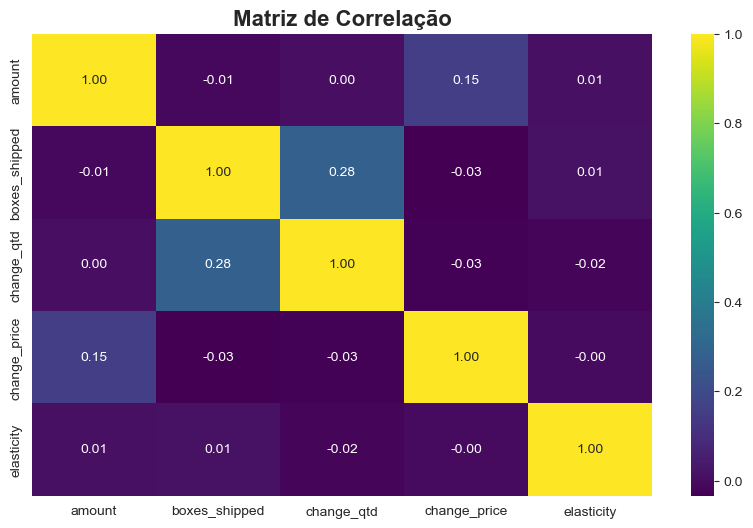

In [45]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    train.corr(numeric_only=True),
    annot=True,        # escreve os valores
    cmap="viridis",    # paleta de cores
    fmt=".2f"          # formatação dos números
)
plt.title("Matriz de Correlação", fontsize=16, fontweight="bold")
plt.show()